# Modeling the Gravitational Slingshot Effect
### Sam Cochran, Jacob Murri Caleb Wilson

It should be noted that a lot of our work is best understood through animations, which can't be embedded into this PDF report. Below is a link to our github, where you can find supplementary code and animation files to look at as needed.

https://github.com/samcochran/Gravitational-Slingshot

https://github.com/samcochran/Gravitational-Slingshot/tree/master/Animations

In [19]:
# Import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style, rcParams
import matplotlib.animation as animation
#might want 3D stuff later
#from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

#Import in-house code
from simulation import *
from plotting import plot_solution, get_acc_quivers, animate_solution

style.use('seaborn')
rcParams['figure.figsize'] = 10, 10


# Theory

In our project we are attempting to model the physics of the slingshot effect, whereby a satellite can swing around a planet and receive a boost in speed so that it can successfully reach its destination. To begin to model this, we first consider Newton's laws applied to $n$ bodies. Let $\mathbf{x}_1(t), \mathbf{x}_2(t), \ldots, \mathbf{x}_n(t) \in \mathbb{R}^3$ be the positions of these $n$ bodies, which have masses $m_1, m_2, \ldots, m_n \geq 0$. Then if $G$ is the universal gravitational constant, the equations of motion given by Newton's Second Law are
$$ 
\mathbf{x}_i''(t) = \sum_{j=1, j\neq i}^n \frac{G m_j (\mathbf{x}_j(t) - \mathbf{x}_i(t))}{\|\mathbf{x}_j(t) - \mathbf{x}_i(t)\|^3}, \qquad 1 \leq i \leq n
$$
Now we can introduce dimensionless time, space, and mass parameters to make our system more tractable. Let $L$, $\Theta$, and $M$ be characteristic length, time, and mass scales, with units of meters, seconds, and kilograms, respectively. Then introduce the dimensionless parameters $\mathbf{u}_i = \mathbf{x}_i/L$, $\tau = t/\Theta$, and $\mu_i = m_i/M$. Then we can rewrite the equations as 
$$ 
\frac{L}{\Theta^2}\mathbf{u}_i''(\tau) = \sum_{j=1, j \neq i}^n \frac{G  M \mu_j L (\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau))}{L^3\|\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau)\|^3}, \qquad  \qquad 1 \leq i \leq n,
$$
which we can simplify to
$$ 
\mathbf{u}_i''(\tau) = \frac{GM \Theta^2}{L^3} \sum_{j=1, j \neq i}^n \frac{\mu_j (\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau))}{\|\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau)\|^3}, \qquad  \qquad 1 \leq i \leq n.
$$
Then by choosing our mass, length, and time scales accordingly, we can set $GM\Theta^2/L^3 = 1$, so that our equations have the dimensionless form
$$ 
\mathbf{u}_i''(\tau) = \sum_{j=1, j \neq i}^n \frac{\mu_j (\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau))}{\|\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau)\|^3}, \qquad  \qquad 1 \leq i \leq n.
$$
By scaling our potential and kinetic energies using the dimensionless form of the energy, $\varepsilon = E \cdot L/(G M^2) = E \cdot \Theta^2/(M L^2)$, we have that
$$
\varepsilon_K = \frac{1}{2}\sum_{i=1}^n \mu_i \|\mathbf{v}_i(\tau)\|^2, \qquad \varepsilon_P = -\frac{1}{2}\sum_{i=1}^n \sum_{j \neq i} \frac{\mu_i \mu_j}{\|\mathbf{u}_i - \mathbf{u}_j\|}.
$$
To make the equations easier to integrate numerically, we can make our system first order by setting $\mathbf{v}_i(\tau) = \mathbf{u}_i'(\tau)$. Then we have the equations
$$ 
\mathbf{u}_i'(\tau) = \mathbf{v}_i(\tau)
; \qquad \mathbf{v}_i'(\tau) = \sum_{j=1, j \neq i}^n \frac{\mu_j (\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau))}{\|\mathbf{u}_j(\tau) - \mathbf{u}_i(\tau)\|^3}, \qquad  \qquad 1 \leq i \leq n.
$$

In our first attempt at a model, we use $n = 3$ bodies: the sun, the planet, and the satellite. We assume that the mass of the satellite is small enough compared to the masses of the sun and planet that it is effectively zero, so we take $m_3 = 0$. Then our equations have the dimensionless form
$$ 
\mathbf{u}_1''(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau)\|^3}
; \qquad  
\mathbf{u}_2''(\tau) = \frac{\mu_1 (\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau)\|^3}
; \qquad
\mathbf{u}_3''(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau)\|^3}
+ \frac{\mu_1(\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau)\|^3}.
$$
Written as a system of first order equations, they appear as 
$$ 
\mathbf{u}_1'(\tau) = \mathbf{v}_1(\tau)
; \qquad 
\mathbf{u}_2'(\tau) = \mathbf{v}_2(\tau)
; \qquad 
\mathbf{u}_3'(\tau) = \mathbf{v}_3(\tau)
;
$$

$$
\mathbf{v}_1'(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_1(\tau)\|^3}
; \qquad  
\mathbf{v}_2'(\tau) = \frac{\mu_1 (\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_2(\tau)\|^3}
; \qquad
\mathbf{v}_3'(\tau) = \frac{ \mu_2 (\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_2(\tau) - \mathbf{u}_3(\tau)\|^3}
+ \frac{\mu_1(\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau))}{\|\mathbf{u}_1(\tau) - \mathbf{u}_3(\tau)\|^3}.
$$

Using the above equations, we have written two functions (simulate_mechanics, and simulate_mechanics_general) which numerically integrate the above equations for this specific 3-body problem and for the general n-body case (respectively). This code is contained in simulation.py, which you can find on our github.

## Testing the Code

We can test our function using some example initial conditions:

In [15]:
# Set an orbit distance and initial velocity to create a circular orbit for the first two masses
r = 1
v = 1/(2*np.sqrt(r))
x1, v1 = np.array([+r, 0, 0]), np.array([0, +v, 0])
x2, v2 = np.array([-r, 0, 0]), np.array([0, v, 0])

# Select initial conditions for the third mass
x3, v3 = np.array([2, 0, 0]), np.array([0, 1, 0])

# Helper function
def create_ic_array(x1, x2, x3, v1, v2, v3): return np.concatenate((x1, x2, x3, v1, v2, v3))

# Get our initial conditions
ic1 = create_ic_array(x1, x2, x3, v1, v2, v3)

Let's test the function on some given initial conditions:

In [16]:
sol = simulate_mechanics(ic1, (0, 5), np.linspace(0, 5, 250))

We can see that the first and second masses stay close to a circle of radius 1:

In [18]:
x1, y1 = sol[0, :], sol[1, :]
x2, y2 = sol[3, :], sol[4, :]

print((x1**2+y1**2)[::10])
print((x2**2+y2**2)[::10])

[1.         1.00000789 1.00013508 1.00071171 1.00226632 1.00568043
 1.01221065 1.02367074 1.04279849 1.07400659 1.12557281 1.22284266]
[1.         1.00000789 1.00013508 1.00071171 1.00226632 1.00568043
 1.01221065 1.02367074 1.04279849 1.07400659 1.12557281 1.22284266]


## Exploring the Model

Now we create some figures to model the dynamics of our system (restricted to the planar problem, for now).  We will use a toy problem to do this initial visualization, i.e. assume both primary masses are of mass 1.

Important: the plotting scheme below assumes the z coordinates of the initial condition are zero (these are indices 2, 5, 8, 11, 14, 17).

In each of these cases, there is something wrong with the outcome.  The plots below, more than anything, illustrate the difficulty of choosing initial conditions that allow for a successful slingshot maneuver.  Our task moving forward is to find a way to choose good initial conditions that allow for successful slingshot maneuvers.

I've gone ahead and hidden the inputs for all but the first plot, as they are essentially identical.

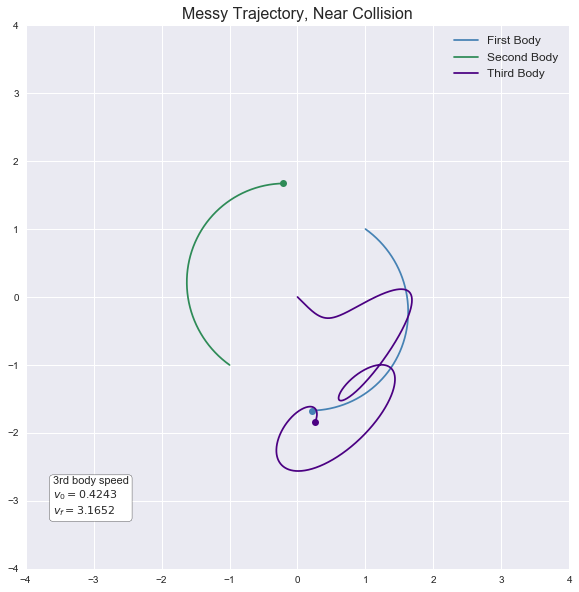

In [20]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .3, -.3, 0]) # Velocity 3 


# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Numerically integrate the system
sol = simulate_mechanics_general(init, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)

plot_solution(sol, 'Messy Trajectory, Near Collision')

# animate_solution(sol, 'Messy Trajectory, Near Collision', 'messy', skip=40)


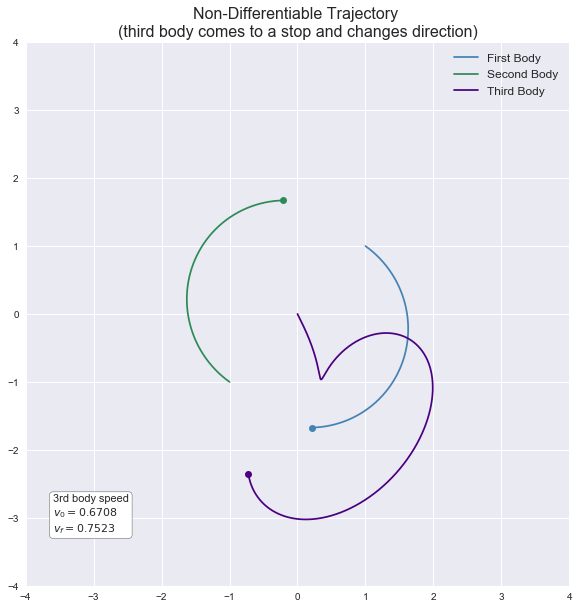

In [21]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .3, -.6, 0]) # Velocity 3 

# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Numerically integrate the system
sol = simulate_mechanics_general(init, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)

#BTW I don't think its non-differentiable I think it just looks like that from this scale, but I could be wrong
title = 'Non-Differentiable Trajectory \n(third body comes to a stop and changes direction)'
plot_solution(sol, title)

# animate_solution(sol, title, 'jagged', skip=40)


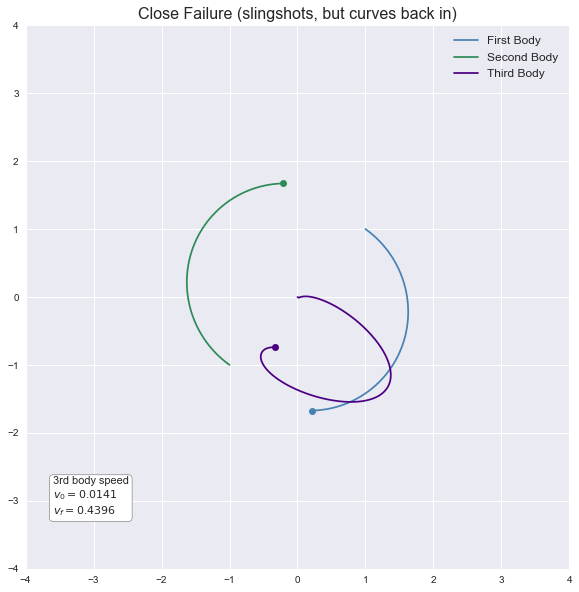

In [22]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .01, -.01, 0]) # Velocity 3 

# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Numerically integrate the system
sol = simulate_mechanics_general(init, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)

title = 'Close Failure (slingshots, but curves back in)'
plot_solution(sol, title)

# animate_solution(sol, title, 'close', skip=40)


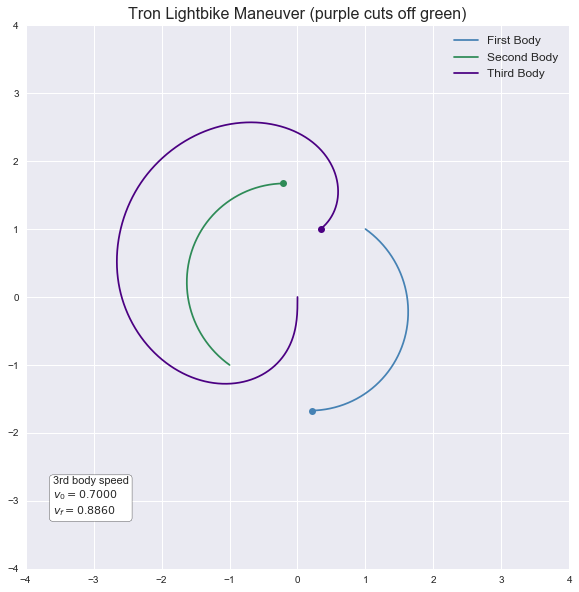

In [23]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 0, -.7, 0]) # Velocity 3 

# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Numerically integrate the system
sol = simulate_mechanics_general(init, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)

title = 'Tron Lightbike Maneuver (purple cuts off green)'
plot_solution(sol, title)

# animate_solution(sol, title, 'tron', skip=40)


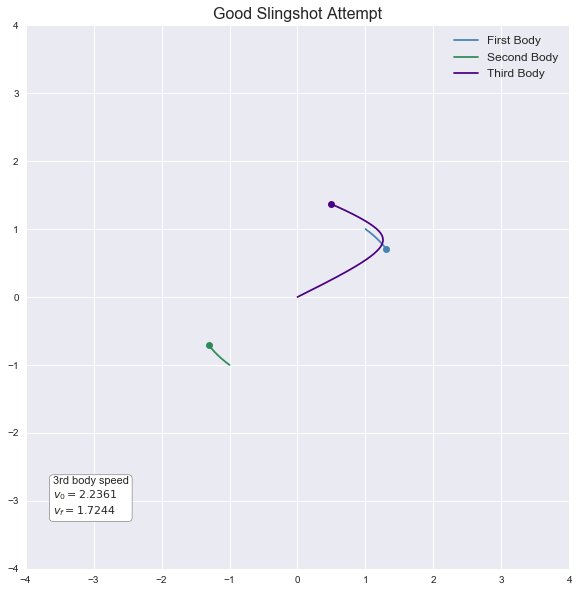

In [26]:
# Set up initial conditions and parameters
t0 = 0
tf = 1
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 2, 1, 0]) # Velocity 3 

# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Numerically integrate the system
sol = simulate_mechanics_general(init, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)

plot_solution(sol, 'Good Slingshot Attempt')

# animate_solution(sol, 'Best Slingshot Attempt', 'best_attempt', skip=40)


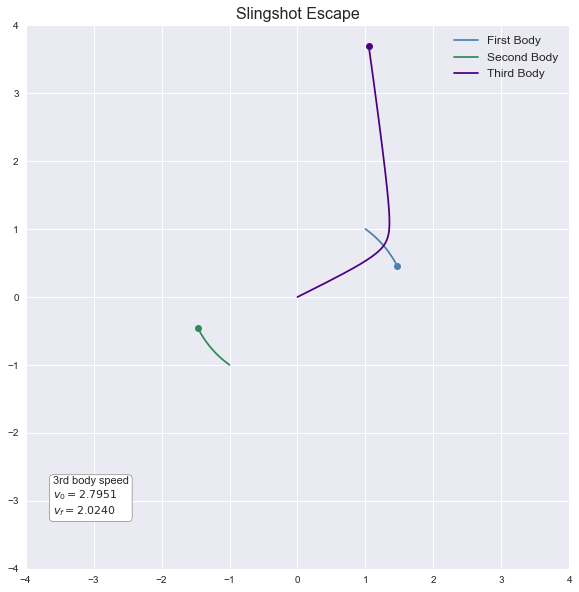

In [27]:
# Set up initial conditions and parameters
t0 = 0
tf = 1.75
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 0, 0, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 2.5, 1.25, 0]) # Velocity 3 (increased enough to allow the 3rd body to escape)

# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Numerically integrate the system
sol = simulate_mechanics_general(init, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)

plot_solution(sol, 'Slingshot Escape')

# animate_solution(sol, 'Slingshot Escape', 'escape', skip=40)


This is the closest we could get to a successful slingshot maneuver on this first attempt.  We came by this mostly by trial and error.  Though we have a long way to go, we note that the third body does indeed gain velocity and change direction by passing very close to the first body, so this is a solid initial model and illustrates our goal.

We further note that this is a very simple toy problem, with the first two primary bodies having mass of unity and the third body being considered as massless, so the masses, velocities, and positions for this model are pretty much meaningless, and only give us information relative to this model.

We now do a sort of grid search idea to really find an optimal slingshot trajectory.

C:\Users\Jacob\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


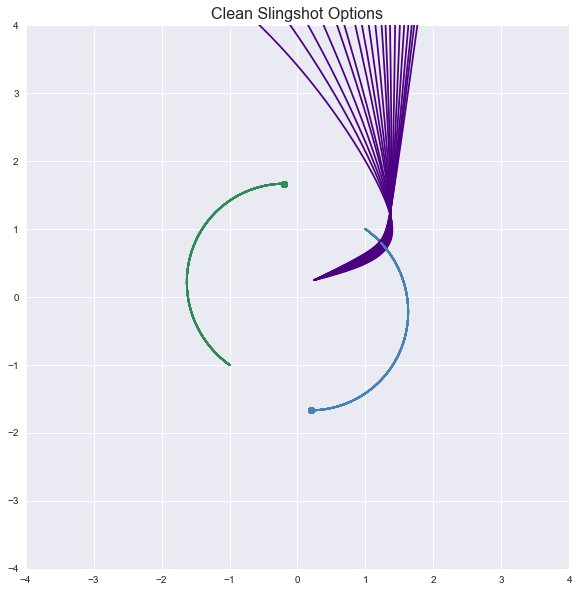

In [30]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 .25, .25, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 2, .5, 0]) # Velocity 3 

# Toy model with equal masses and m3 = 0
m = [1, 1, 0]

# Solve the system for each grid point, sort of
perturb = np.zeros_like(init)
perturb[[15, 16]] = .05
fig, ax = plt.subplots()
for k in range(20):
    
    # Numerically integrate the system
    sol = simulate_mechanics_general(init + k*perturb, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)
    plot_solution(sol, 'Clean Slingshot Options', ax = ax, show_speed=False)
    ax.legend([])


We can also see that changing the 3rd mass to a small nonzero value makes a small difference in the trajectories of one of the large bodies:

C:\Users\Jacob\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


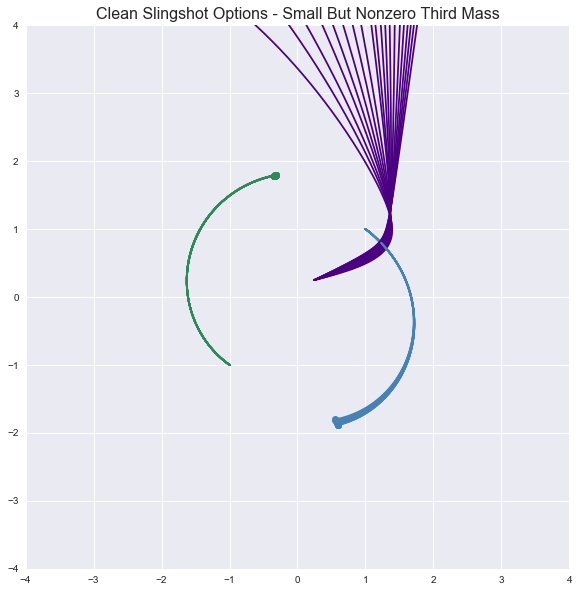

In [34]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 .25, .25, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 2, .5, 0]) # Velocity 3 

# Toy model with equal masses, but m3 = 0.01
m = [1, 1, 0.01]

# Solve the system for each grid point, sort of
perturb = np.zeros_like(init)
perturb[[15, 16]] = .05
fig, ax = plt.subplots()
for k in range(20):
    
    # Numerically integrate the system
    sol = simulate_mechanics_general(init + k*perturb, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)
    plot_solution(sol, 'Clean Slingshot Options - Small But Nonzero Third Mass', ax = ax, show_speed=False)
    ax.legend([])


As we can see, with these higher starting velocities, the problem appears quite stable.  See the plot below however to note the chaotic behavior that appears with lower starting velocities.  If the velocity is not great enough, slight changes to initial conditions result in drastically different behavior, with some slingshotting down as we would like, and others looping around unpredictably.  This is perhaps something to keep in mind as we proceed, especially as we consider what realistic velocities for spacecraft are relative to the planetary bodies.  We might need the model to be more robust to lower velocities, depending on what the engineering constraints are for realistic spacecraft speeds.

C:\Users\Jacob\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


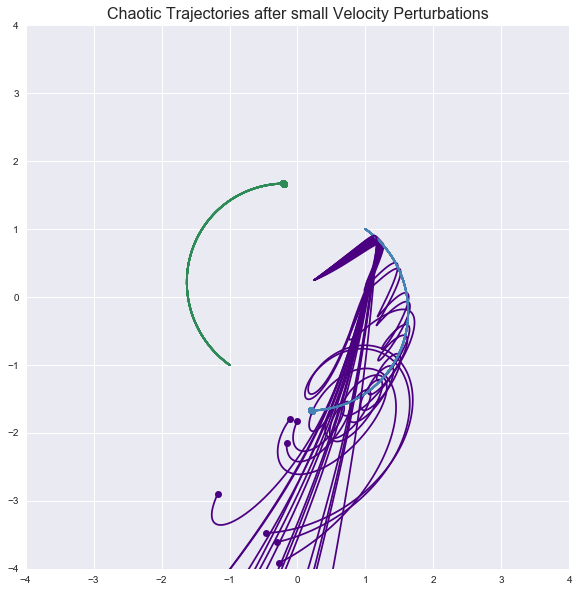

In [35]:
# Set up initial conditions and parameters
t0 = 0
tf = 10
init = np.array([1, 1, 0, # Position 1
                 -1, -1, 0, # Position 2
                 .25, .25, 0, # Position 3
                 .35, -.25, 0, # Velocity/Momentum 1
                 -.35, .25, 0, # Velocity/Momentum 2
                 .7, .3, 0]) # Velocity 3 

# Toy model with equal masses and m3=0
m = [1, 1, 0]

# Solve the system for each grid point, sort of
perturb = np.zeros_like(init)
perturb[[15, 16]] = .05
fig, ax = plt.subplots()
for k in range(20):
    # Numerically integrate the system
    sol = simulate_mechanics_general(init + k*perturb, t_span=(t0, tf), t_eval= np.linspace(t0, tf, 10000), m=m)
    plot_solution(sol, 'Chaotic Trajectories after small Velocity Perturbations', ax = ax, show_speed=False)
    ax.legend([])


### Next Steps

The next step in our project will involve making a few changes to allow our model to handle more sophisticated scenarios.  We have improved our solver to handle a nonzero third mass, as well as an arbitrary number of bodies.  The next step, then, will be to put in more realistic values for the masses, positions, and momenta of our bodies to make sure our model generalizes well to real physical scenarios.  We will also work on visualizing our solutions with this more sophisticated model.  

It should be noted that we anticipate some interesting pitfalls that we'll have to circumvent when we put real values in, since we will be dealing with lots of interactions between very large and very small bodies, so floating point errors will likely abound.  We will have to deal with this and find out how to overcome this issue as it comes up.

We are also working on transforming our data to provide a better way of visualizing.  We hope to be able to put things into rotational coordinates with respect to the larger bodies to make it easier to see and find slingshot trajectories.